# Let's Face It 

**Team Members:** Georgiy Sekretaryuk, Rafael Arbex-Murut, Yeshwanth Somu

**Data Set:** Facial Recognition Dataset
- https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset?select=Testing

**Data Set Description:**

This dataset contains folders pertaining to different expressions of the human face, such as Surprise, Anger, Happiness, Sad, Neutral, Fear. The training set consists of 28,079 samples in total with the testing set consisting of 7,178 samples in total. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The purpose of this project is to analyze facial images to predict emotion.

**Number of Attributes:** 2304

**Attribute Description:** Each attribute is a grayscale value of each of the 48 x 48 pixels.

**Data Source:** Kaggle

In [1]:
# SETUP

import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn import metrics
tf.get_logger().setLevel('INFO')

2023-08-02 23:45:14.421413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 23:45:14.450752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 23:45:14.452112: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 23:45:15.040717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading Data

In [2]:
# Function to load images from a folder
def load_images_from_folder(folder_path, label_mapping):
    images = []
    labels = []

    #load each image file
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))

        #check if loaded properly
        if img is not None:

            images.append(np.array(img)) #turn image to array
            # print(folder_path)
            folder_path = folder_path.replace("\\", "/")
            folder_name = folder_path.split("/")[-1]  # Extract folder name from path
            # print(folder_name)
            label = label_mapping[folder_name]  # Assign label based on folder name
            labels.append(label)  # Assign the folder index as the label

    return images, labels

def load_dataset(data_folder, return_label_names=False):
    X = []
    Y = []

    label_mapping = {}  # Dictionary to map folder names to label values
    label_counter = 0

    #cycle through each folder, get folder path
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        # print("Load_dataset is looping through", folder_path)

        #check if a folder or a stray file
        if os.path.isdir(folder_path):

            #count folders to assign index
            label_mapping[folder_name] = label_counter
            label_counter += 1

            #load images and labels, add to X/Y list
            images, labels = load_images_from_folder(folder_path, label_mapping)
            X.extend(images)
            Y.extend(labels)
    
        else:
            print(f"{folder_path} is not a folder.")

    #pull out label names
    label_names = list(label_mapping.keys())

    if return_label_names:
        label_names = list(label_mapping.keys())
        return np.array(X), np.array(Y), label_names
    else:
        return np.array(X), np.array(Y)

# Load the training dataset
train_folder = 'data/Training/Training'
X_train, Y_train, label_names = load_dataset(train_folder, return_label_names=True)

# Load the testing dataset
test_folder = 'data/Testing/Testing'
X_test, Y_test, = load_dataset(test_folder)

# Flatten the label vectors
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


data/Testing/Testing/.DS_Store is not a folder.


In [3]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print(label_names)

print(Y_train)

X_train.shape: (28273, 48, 48)
Y_train.shape: (28273,)
X_test.shape: (7067, 48, 48)
Y_test.shape: (7067,)
['Happy', 'Suprise', 'Angry', 'Neutral', 'Fear', 'Sad']
[0 0 0 ... 5 5 5]


In [4]:
print(len(Y_train[Y_train == 0]))
print(len(Y_train[Y_train == 1]))
print(len(Y_train[Y_train == 2]))
print(len(Y_train[Y_train == 3]))
print(len(Y_train[Y_train == 4]))
print(len(Y_train[Y_train == 5]))

7215
3171
3995
4965
4097
4830


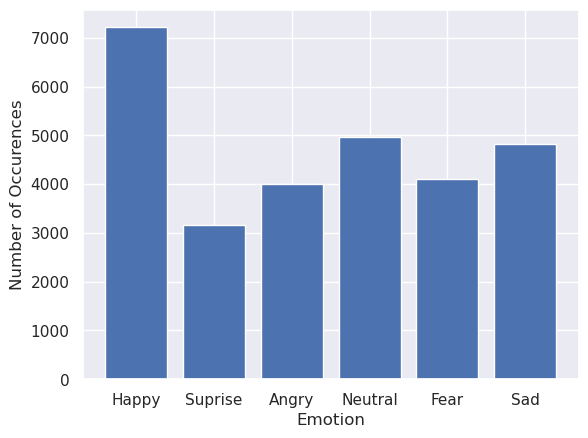

In [5]:
n = [len(Y_train[Y_train == 0]), len(Y_train[Y_train == 1]), len(Y_train[Y_train == 2]), len(Y_train[Y_train == 3]), len(Y_train[Y_train == 4]), len(Y_train[Y_train == 5])]
plt.bar(label_names, n)
plt.xlabel("Emotion")
plt.ylabel ("Number of Occurences")
plt.show()

This block here normalizes the pixels by making them a value between 0 and 1

In [6]:
X_train = X_train / 255
X_test = X_test / 255

### Visualizing Images in Dataset

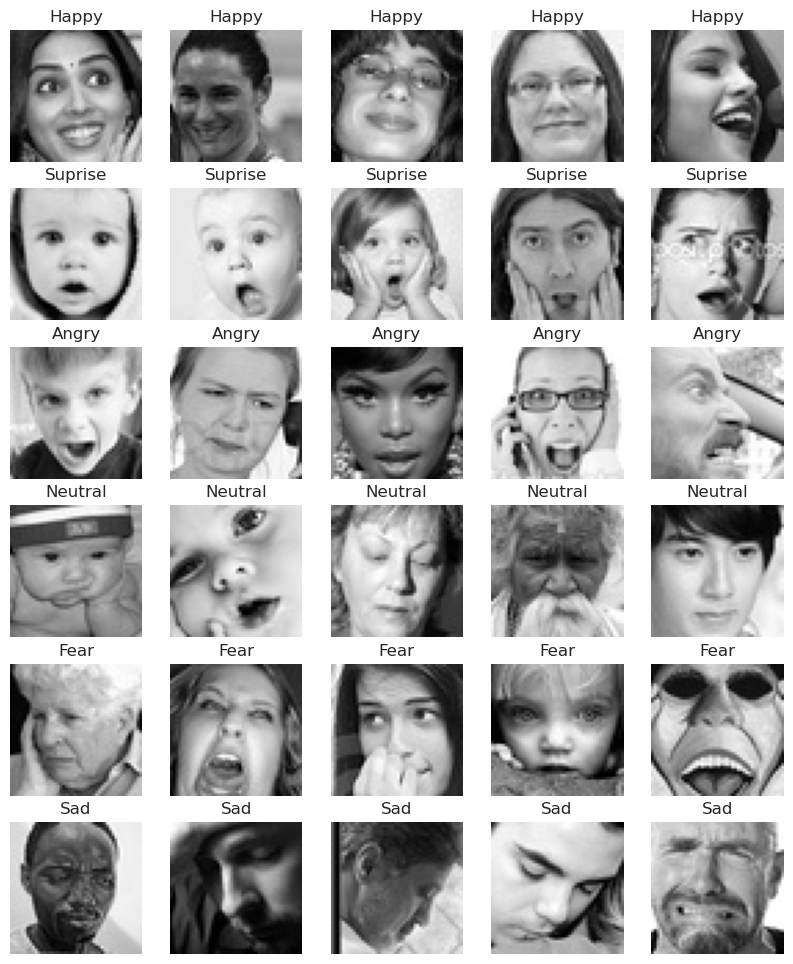

In [7]:
#plot 5 images for each label

num_images_to_show = 5

fig, axs = plt.subplots(len(label_names), ncols=num_images_to_show, figsize=(10, 12))
for label in range(len(label_names)):
    counter = 0 
    for i in range(len(Y_train)):
        if Y_train[i] == label:
            image = X_train[i]
            axs[label, counter].imshow(image, cmap='gray')
            axs[label, counter].set_title(label_names[label])
            axs[label, counter].axis('off')
            counter += 1

            #if loaded 5 images per row/label, break
            if counter == 5:  
                break
plt.show()

### Building the Model

In [8]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [9]:
#Checking the shape on data
X_train.shape
Y_train.shape

(28273,)

This is where the model gets build. It's a sequential model with two sets of convolutional layers followed by a pooling layer. Then some additional layers are added. All the layers are visible once this block is run. The comments with one # are from the homework. My comments have ##.

The biggest change to note here is that the activation function for the last layer is softmax, as this is a multiclass classification problem.

In [11]:
model = tf.keras.Sequential()

# add first convolution layer to the model
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
##Same as hw
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
##Same as hw
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
##Same as hw
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
##Same as hw
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)

##Changed the activation to softmax as this is a multiclass classification
##Units changes to length of label names, should be 6
model.add(tf.keras.layers.Dense(
    units=len(label_names),
    name='fc_2',
    activation='softmax'))


# build model and print summary
##Changed input shape. Set last parameter as 1 since we have a single channel, but not sure how this affects the model
tf.random.set_seed(1)
model.build(input_shape=(None, 48, 48, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 48, 48, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 24, 24, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 24, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              9438208   
                                                                 
 dropout_1 (Dropout)         (None, 1024)             

Change the optimizer and loss to the ones used in the multiclass classification homework.

In [12]:
##Changes optimizer and loss
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=['accuracy'])

In [13]:
##Changes training and validation data
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, Y_train,
                    epochs=10, 
                    validation_data=(X_test, Y_test)
)

Epoch 1/10
884/884 [==============================] - 108s 122ms/step - loss: 1.5860 - accuracy: 0.3614 - val_loss: 1.4623 - val_accuracy: 0.4208
Epoch 2/10
884/884 [==============================] - 104s 118ms/step - loss: 1.4091 - accuracy: 0.4413 - val_loss: 1.3460 - val_accuracy: 0.4694
Epoch 3/10
884/884 [==============================] - 116s 131ms/step - loss: 1.2945 - accuracy: 0.4984 - val_loss: 1.2824 - val_accuracy: 0.4974
Epoch 4/10
884/884 [==============================] - 120s 135ms/step - loss: 1.2018 - accuracy: 0.5389 - val_loss: 1.2534 - val_accuracy: 0.5131
Epoch 5/10
884/884 [==============================] - 104s 117ms/step - loss: 1.1008 - accuracy: 0.5828 - val_loss: 1.2163 - val_accuracy: 0.5353
Epoch 6/10
884/884 [==============================] - 111s 126ms/step - loss: 0.9949 - accuracy: 0.6255 - val_loss: 1.2260 - val_accuracy: 0.5373
Epoch 7/10
884/884 [==============================] - 105s 118ms/step - loss: 0.8701 - accuracy: 0.6776 - val_loss: 1.2473 -

--------

In [14]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

221/221 [==============================] - 3s 13ms/step
[0 0 3 ... 5 2 5]


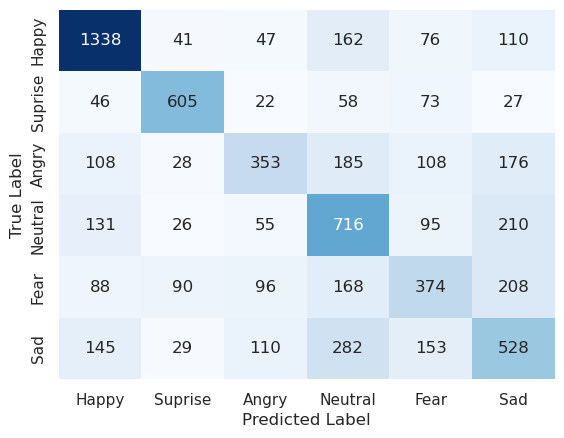

              precision    recall  f1-score   support

           0      0.721     0.754     0.737      1774
           1      0.739     0.728     0.733       831
           2      0.517     0.368     0.430       958
           3      0.456     0.581     0.511      1233
           4      0.425     0.365     0.393      1024
           5      0.419     0.423     0.421      1247

    accuracy                          0.554      7067
   macro avg      0.546     0.537     0.538      7067
weighted avg      0.553     0.554     0.550      7067



In [15]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))

## Pixel Analysis

In [16]:
first_coord = 24
second_coord = 24

angry_faces = X_train[np.where(Y_train == 0)]
angry_center = []
for i in range(0,len(angry_faces)): angry_center.append(angry_faces[i][first_coord,second_coord])
print("Mean of all angry images' center pixel is: ", np.mean(angry_center))
print("Standard Deviation of all sneaker images' center pixel is: ", np.std(angry_center))
print("\n")


fear_faces = X_train[np.where(Y_train == 1)]
fear_center = []
for i in range(0,len(fear_faces)): fear_center.append(fear_faces[i][first_coord,second_coord])
print("Mean of all fear images' center pixel is: ", np.mean(fear_center))
print("Standard Deviation of all fear images' center pixel is: ", np.std(fear_center))
print("\n")

happy_faces = X_train[np.where(Y_train == 2)]
happy_center = []
for i in range(0,len(happy_faces)): happy_center.append(happy_faces[i][first_coord,second_coord])
print("Mean of all happy images' center pixel is: ", np.mean(happy_center))
print("Standard Deviation of all happy images' center pixel is: ", np.std(happy_center))
print("\n")

neutral_faces = X_train[np.where(Y_train == 3)]
neutral_center = []
for i in range(0,len(neutral_faces)): neutral_center.append(neutral_faces[i][first_coord,second_coord])
print("Mean of all neutral images' center pixel is: ", np.mean(neutral_center))
print("Standard Deviation of all neutral images' center pixel is: ", np.std(neutral_center))
print("\n")

sad_faces = X_train[np.where(Y_train == 4)]
sad_center = []
for i in range(0,len(sad_faces)): sad_center.append(sad_faces[i][first_coord,second_coord])
print("Mean of all sad images' center pixel is: ", np.mean(sad_center))
print("Standard Deviation of all sad images' center pixel is: ", np.std(sad_center))
print("\n")

surprise_faces = X_train[np.where(Y_train == 5)]
surprise_center = []
for i in range(0,len(surprise_faces)): surprise_center.append(surprise_faces[i][first_coord,second_coord])
print("Mean of all suprise images' center pixel is: ", np.mean(surprise_center))
print("Standard Deviation of all suprise images' center pixel is: ", np.std(surprise_center))
print("\n")

Mean of all angry images' center pixel is:  0.6557123639476581
Standard Deviation of all sneaker images' center pixel is:  0.17844924919391203


Mean of all fear images' center pixel is:  0.7236722503570966
Standard Deviation of all fear images' center pixel is:  0.16189416789663935


Mean of all happy images' center pixel is:  0.6301396353284743
Standard Deviation of all happy images' center pixel is:  0.19814845019799127


Mean of all neutral images' center pixel is:  0.6498422289358844
Standard Deviation of all neutral images' center pixel is:  0.1943003540045892


Mean of all sad images' center pixel is:  0.6631930585268034
Standard Deviation of all sad images' center pixel is:  0.1873565507768664


Mean of all suprise images' center pixel is:  0.6160012990703527
Standard Deviation of all suprise images' center pixel is:  0.2023016707426697




In [17]:
first_coord = 12
second_coord = 30

angry_faces = X_train[np.where(Y_train == 0)]
angry_center = []
for i in range(0,len(angry_faces)): angry_center.append(angry_faces[i][first_coord,second_coord])
print("Mean of all angry images' center pixel is: ", np.mean(angry_center))
print("Standard Deviation of all sneaker images' center pixel is: ", np.std(angry_center))
print("\n")


fear_faces = X_train[np.where(Y_train == 1)]
fear_center = []
for i in range(0,len(fear_faces)): fear_center.append(fear_faces[i][first_coord,second_coord])
print("Mean of all fear images' center pixel is: ", np.mean(fear_center))
print("Standard Deviation of all fear images' center pixel is: ", np.std(fear_center))
print("\n")

happy_faces = X_train[np.where(Y_train == 2)]
happy_center = []
for i in range(0,len(happy_faces)): happy_center.append(happy_faces[i][first_coord,second_coord])
print("Mean of all happy images' center pixel is: ", np.mean(happy_center))
print("Standard Deviation of all happy images' center pixel is: ", np.std(happy_center))
print("\n")

neutral_faces = X_train[np.where(Y_train == 3)]
neutral_center = []
for i in range(0,len(neutral_faces)): neutral_center.append(neutral_faces[i][first_coord,second_coord])
print("Mean of all neutral images' center pixel is: ", np.mean(neutral_center))
print("Standard Deviation of all neutral images' center pixel is: ", np.std(neutral_center))
print("\n")

sad_faces = X_train[np.where(Y_train == 4)]
sad_center = []
for i in range(0,len(sad_faces)): sad_center.append(sad_faces[i][first_coord,second_coord])
print("Mean of all sad images' center pixel is: ", np.mean(sad_center))
print("Standard Deviation of all sad images' center pixel is: ", np.std(sad_center))
print("\n")

surprise_faces = X_train[np.where(Y_train == 5)]
surprise_center = []
for i in range(0,len(surprise_faces)): surprise_center.append(surprise_faces[i][first_coord,second_coord])
print("Mean of all suprise images' center pixel is: ", np.mean(surprise_center))
print("Standard Deviation of all suprise images' center pixel is: ", np.std(surprise_center))
print("\n")

Mean of all angry images' center pixel is:  0.5634655469949587
Standard Deviation of all sneaker images' center pixel is:  0.2160317088189045


Mean of all fear images' center pixel is:  0.5917660662498995
Standard Deviation of all fear images' center pixel is:  0.20585796805268805


Mean of all happy images' center pixel is:  0.5458342536013153
Standard Deviation of all happy images' center pixel is:  0.22177849422187393


Mean of all neutral images' center pixel is:  0.5292932883123038
Standard Deviation of all neutral images' center pixel is:  0.22671638077136913


Mean of all sad images' center pixel is:  0.5590594744121715
Standard Deviation of all sad images' center pixel is:  0.2167549246140489


Mean of all suprise images' center pixel is:  0.504989242073641
Standard Deviation of all suprise images' center pixel is:  0.22933128027430247




In [18]:
label_names

['Happy', 'Suprise', 'Angry', 'Neutral', 'Fear', 'Sad']